# Spending on Nondurables During the Great 

<p style="text-align: center;"><small><small><small>Generator: QuARK-make/notebooks_byname</small></small></small></p>

In [1]:
# Initial imports and notebook setup, click arrow to show

import matplotlib.pyplot as plt

## Import some things from cstwMPC

from tqdm import tqdm

import numpy as np
from copy import deepcopy

import HARK # Prevents import error from Demos repo
from HARK.utilities import plotFuncs

### There Was a Big Drop in Consumption ... 
Between the second and fourth quarters of 2018, nondurables consumption spending in the U.S. dropped by an unprecedented 6.4 percent.  High frequency data show a drop in retail sales of something like 10 percent between the weekend before the Lehmann collapse and the weekend after Lehmann.  

### ... and Uncertainty Could Induce A Drop In Consumption ...  
Increased "uncertainty" has become a popular explanation of much of what happened in the Great Recession -- including this drop.  Qualitatively, it is well known that a perceived increase in labor income uncertainty should induce more saving (less consumption) for precautionary reasons.

### ... But Is the Story _Quantitatively_ Plausible?
But if explaining a 6.4 percent drop in consumption would require an implausibly large increase in uncertainty, the story that uncertainty explains the consumption drop is implausible.  

### Transitory Shocks, Permanent Shocks, or Unemployment
The $\texttt{ConsIndShockConsumerType}$ model incorporates three kinds of uncertainty: Unemployment spells, during which income is reduced to some small proportion of its normal level; and, for consumers who remain employed, transitory and permanent shocks with standard deviations $\sigma_{\theta}$ and $\sigma_{\psi}$.  

### The Question:
How large an increase in the standard deviation of $\sigma_{\psi}$ would be necessary to induce a 6.4 percent drop in consumption in one quarter?  What about $\sigma_{\theta}$?  How high would the perceived unemployment probability have to be?

The first step is to create the agents we want to solve the model for.

Model set up:
- "Standard" infinite horizon consumption/savings model, with mortality and permanent and temporary shocks to income
- Ex-ante heterogeneity in consumers' discount factors
    
With this basic setup, HARK's IndShockConsumerType is the appropriate subclass of $\texttt{AgentType}$. So we need to prepare the parameters to create instances of that class.


In [2]:
init_infinite = {
    "CRRA":1.0,                    # Coefficient of relative risk aversion 
    "Rfree":1.01/(1.0 - 1.0/240.0), # Survival probability,
    "PermGroFac":[1.000**0.25], # Permanent income growth factor (no perm growth),
    "PermGroFacAgg":1.0,
    "BoroCnstArt":0.0,
    "CubicBool":False,
    "vFuncBool":False,
    "PermShkStd":[(0.01*4/11)**0.5],  # Standard deviation of permanent shocks to income
    "PermShkCount":7,  # Number of points in permanent income shock grid
    "TranShkStd":[(0.01*4)**0.5],  # Standard deviation of transitory shocks to income,
    "TranShkCount":5,  # Number of points in transitory income shock grid
    "UnempPrb":0.07,  # Probability of unemployment while working
    "IncUnemp":0.15,  # Unemployment benefit replacement rate
    "UnempPrbRet":None,
    "IncUnempRet":None,
    "aXtraMin":0.00001,  # Minimum end-of-period assets in grid
    "aXtraMax":20,  # Maximum end-of-period assets in grid
    "aXtraCount":20,  # Number of points in assets grid,
    "aXtraExtra":[None],
    "aXtraNestFac":3,  # Number of times to 'exponentially nest' when constructing assets grid
    "LivPrb":[1.0 - 1.0/240.0],  # Survival probability
    "DiscFac":0.97,             # Default intertemporal discount factor, # dummy value, will be overwritten
    "cycles":0,
    "T_cycle":1,
    "T_retire":0,
    'T_sim':2000,  # Number of periods to simulate (idiosyncratic shocks model, perpetual youth)
    'T_age':1000,
    'IndL': 10.0/9.0,  # Labor supply per individual (constant),
    'aNrmInitMean':np.log(0.00001),
    'aNrmInitStd':0.0,
    'pLvlInitMean':0.0,
    'pLvlInitStd':0.0,
    'AgentCount':10000,
}

Now we import the class itself and make a baseline type.

In [4]:
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType
BaselineType = IndShockConsumerType(**init_infinite)

In [5]:
# For this exercise, we will introduce ex ante heterogeneity, so the baseline type will be copied several times.

# First, let's create a list with seven copies of our baseline type.

In [6]:
# A list in python can contain anything -- including consumers
num_consumer_types   = 7 # declare the number of types we want
ConsumerTypes = [] # initialize an empty list

for nn in range(num_consumer_types):
    # Now create the types, and append them to the list ConsumerTypes
    NewType = deepcopy(BaselineType)
    NewType.seed = nn # give each consumer type a different RNG seed
    ConsumerTypes.append(NewType)

Now we can give each of the consumer types their own discount factor. (This distribution of parameters was estimated in the paper ["The Distribution of Wealth and the Marginal Propensity to Consume" by Carroll, Slacalek, Tokuoka, and White (2017) (cstwMPC)](http://econ.jhu.edu/people/ccarroll/papers/cstwMPC).  

In [7]:
# Seven types is enough to approximate the uniform distribution (5 is not quite enough)
from HARK.utilities import approxUniform

# Calibrations from cstwMPC
bottomDiscFac  = 0.9800
topDiscFac     = 0.9934
DiscFac_list   = approxUniform(N=num_consumer_types,bot=bottomDiscFac,top=topDiscFac)[1]

# Now, assign the discount factors
for j in range(num_consumer_types):
    ConsumerTypes[j].DiscFac = DiscFac_list[j]
    ConsumerTypes[j].quiet   = True # Turn off some output

Our agents now exist and have a concept of the problem they face, but we still need them to solve that problem.

Once we have solved each type of consumer's individual problem, we need to know the distribution of wealth (and permanent income) that the population would achieve in the long run.

The cell below does both of those tasks, looping through the consumer types. For each one, it solves that type's infinite horizon model, then simulates 1000 periods to generate an approximation to the long run distribution of wealth.

In [8]:
# tqdm presents a pretty bar that interactively shows how far the calculations have gotten
for ConsumerType in tqdm(ConsumerTypes):
    ## We configured their discount factor above.  Now solve
    ConsumerType.solve(verbose=False)
    
    # Now simulate many periods to get to the stationary distribution
    ConsumerType.T_sim = 2000
    ConsumerType.initializeSim()
    ConsumerType.simulate()

100%|██████████| 7/7 [01:18<00:00, 11.27s/it]


With all of that setup taken care of, let's write some functions to run our counterfactual exercise and extract the information we want.

First, let's define a simple function that merely calculates the average consumption level across the entire population in the most recent simulated period.

In [9]:
# We just merge the cNrm and pNrm lists already constructed for each ConsumerType
def calcAvgC(ConsumerTypes):
    """
    This function calculates average consumption in the economy in last simulated period,
    averaging across ConsumerTypes.
    """
    # Make arrays with all types' (normalized) consumption and permanent income level
    # The brackets indicate that the contents will be a list (in this case, of lists)
    cNrm = np.concatenate([ThisType.cNrmNow for ThisType in ConsumerTypes])
    pLvl = np.concatenate([ThisType.pLvlNow for ThisType in ConsumerTypes])
    
    # Calculate and return average consumption level in the economy
    avgC = np.mean(cNrm*pLvl) # c is the ratio to p, so C = c*p
    return avgC

Now let's create a function to run the experiment we want -- change income uncertainty, and see how consumption changes.
To keep the code block below (mostly) clean, we'll describe the procedure below step by step here, with accompanying annotations in the codeblock.

1. Initialize an empty list to hold the changes in consumption that happen after parameters change, and calculate average consumption before the change in uncertainty.
2. Loop through the new uncertainty parameter values to assign. For each parameter value:
 1. Assign the parameter value to the agents
 2. Re-solve the agent's model under that degree of uncertainty
 3. Construct a population of agents distributed according to the pre-crisis steady state
 4. Simulate one more period-- the first period after the change in risk.
 5. Calculate the population average consumption level given the new consumption rule
 6. Calculate the new average consumption level as percentage change vs the prior level.
3. Return the list of percentage changes

In [10]:
# Whenever you define a function, you should describe it (with a "docstring")
def calcConsChangeAfterUncertaintyChange(OriginalTypes,NewVals,ParamToChange):
    '''
    Calculate the change in aggregate consumption for a list of values that a 
    parameter will take on.
    
    Parameters
    ----------
    OriginalTypes : [IndShockConsumerType]
        List of consumer types, who have already had their "pre-shock" problem solved and simulated.
    NewVals : np.array
        List or array of new values that the parameter of interest will take on.
    ParamToChange : str
        Name of the income distribution parameter that will be changed.
        
    Returns
    -------
    ChangesInConsumption : [float]
        List of changes in aggregate consumption corresponding to the values in NewVals, as a percentage
        of the original aggregate consumption level.
    '''
    ChangesInConsumption = [] # Step 1
    OldAvgC = calcAvgC(OriginalTypes)

    # Step 2 (the loop over counterfactual parameter values)
    for NewVal in tqdm(NewVals):
        if ParamToChange in ["PermShkStd","TranShkStd"]:
            ThisVal = [NewVal]
        else:
            ThisVal = NewVal

        ConsumerTypesNew = deepcopy(OriginalTypes)          
        for index,ConsumerTypeNew in enumerate(ConsumerTypesNew):
            setattr(ConsumerTypeNew,ParamToChange,ThisVal) # Step 2A   
            ConsumerTypeNew.updateIncomeProcess()
            ConsumerTypeNew.solve(verbose=False) # Step 2B
            
            ConsumerTypeNew.initializeSim() # Step 2C
            ConsumerTypeNew.aNrmNow = OriginalTypes[index].aNrmNow
            ConsumerTypeNew.pLvlNow = OriginalTypes[index].pLvlNow
            
            ConsumerTypeNew.simOnePeriod() # Step 2D
            
            NewAvgC = calcAvgC(ConsumerTypesNew) # Step 2E
        ChangeInConsumption = 100. * (NewAvgC - OldAvgC) / OldAvgC # Step 2F
        ChangesInConsumption.append(ChangeInConsumption)

    return ChangesInConsumption # Step 3, returning the output

Our counterfactual experiment function takes three inputs-- consumer types, counterfactual values, and the name of the parameter we want to change. For the sake of convenience, let's define small functions to run the experiment for each parameter with just a single input.

In [11]:
# Trivial functions can be useful in making the logic of your program clear
def calcConsChangeAfterPermShkChange(newVals):
    return calcConsChangeAfterUncertaintyChange(ConsumerTypes,newVals,"PermShkStd")

def calcConsChangeAfterTranShkChange(newVals):
    return calcConsChangeAfterUncertaintyChange(ConsumerTypes,newVals,"TranShkStd")

def calcConsChangeAfterUnempPrbChange(newVals):
    return calcConsChangeAfterUncertaintyChange(ConsumerTypes,newVals,"UnempPrb")

Now we can finally run our experiment.  In the cell below, we generate a plot of the change in aggregate consumption vs the (underlying) standard deviation of permanent income shocks.

100%|██████████| 10/10 [00:26<00:00,  2.63s/it]


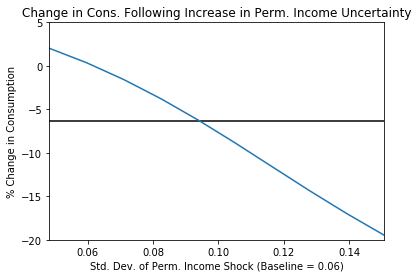

In [12]:
# Calculate the consequences of an "MIT shock" to the standard deviation of permanent shocks
ratio_min = 0.8 # minimum number to multiply uncertainty parameter by
TargetChangeInC = -6.3 # Source: FRED
num_points = 10 # number of parameter values to plot in graphs. More=slower

# First change the variance of the permanent income shock
perm_ratio_max = 2.5 # Put whatever value in you want!  maximum number to multiply var of perm income shock by

perm_min = BaselineType.PermShkStd[0] * ratio_min
perm_max = BaselineType.PermShkStd[0] * perm_ratio_max

plt.ylabel('% Change in Consumption')
plt.xlabel('Std. Dev. of Perm. Income Shock (Baseline = ' + str(round(BaselineType.PermShkStd[0],2)) + ')')
plt.title('Change in Cons. Following Increase in Perm. Income Uncertainty')
plt.ylim(-20.,5.)
plt.hlines(TargetChangeInC,perm_min,perm_max)
# The expression below shows the power of python
plotFuncs([calcConsChangeAfterPermShkChange],perm_min,perm_max,N=num_points)

The figure shows that if people's beliefs about the standard deviation of permanent shocks to their incomes had changed from 0.06 (the default value) to about 0.012, the model would predict an immediate drop in consumption spending of about the magnitude seen in 2008.

The question is whether this is a reasonable or an unreasonable magnitude for a change in uncertainty. Some perspective on that question is offered by the large literature that attempts to estimate the magnitude of persistent or permanent shocks to household income. The answer varies substantially across household types, countries, and time periods, but our sense of the literature is that the whole span of the territory between 0.04 and ranging nearly up to 0.20 is well populated (in the sense that substantial populations of people or countries have been estimated to experience shocks of this magnitude).

So, the degree to which income uncertainty would have had to rise in order to explain the drop in consumption in the Great Recession is quite moderate, compared to the variation that is estimated already to exist across people, places, times, and countries.


### PROBLEM

Compute the change in transitory uncertainty and of unemployment risk that would be sufficient to make consumption fall by the appropriate amount (by making a figure similar to the one above). Brifely explain your results in intuitive terms.

100%|██████████| 10/10 [00:27<00:00,  2.77s/it]


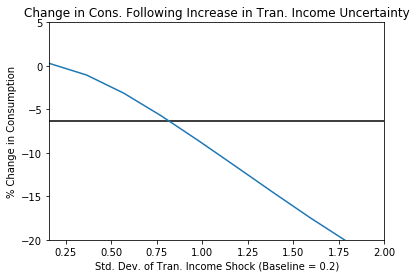

In [13]:
#Q1. Compute the change in transitory uncertainty risk. 
# "MIT" shocks appears when the econonomy is in the steady state. So, I calculate the consequences of an "MIT shock" to the st.dev. of transitory shocks

ratio_min = 0.8 # min number to multiply uncertainty parameter by
TargetChangeInC = -6.3 # Source: FRED
num_points = 10 # number of parameter values to plot in graphs. More=slower

# First change the variance of the permanent income shock
tran_ratio_max = 10 # Put whatever value in you want!  maximum number to multiply var of perm income shock by

tran_min = BaselineType.TranShkStd[0] * ratio_min
tran_max = BaselineType.TranShkStd[0] * tran_ratio_max

plt.ylabel('% Change in Consumption')
plt.xlabel('Std. Dev. of Tran. Income Shock (Baseline = ' + str(round(BaselineType.TranShkStd[0],2)) + ')')
plt.title('Change in Cons. Following Increase in Tran. Income Uncertainty')
plt.ylim(-20.,5.)
plt.hlines(TargetChangeInC,tran_min,tran_max)
# The expression below shows the power of python
plotFuncs([calcConsChangeAfterTranShkChange],tran_min,tran_max,N=num_points)


100%|██████████| 10/10 [00:30<00:00,  3.07s/it]


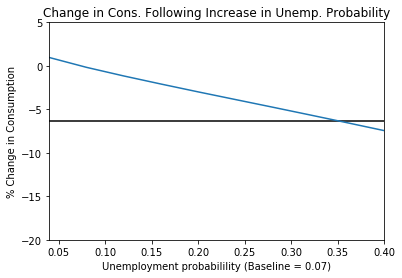

In [14]:
#Compute the change in unemployment risk sufficient to make consumption fall by the appropriate amount.
#So I calculate the consequences of the "MIT shock to the unemployment shocks

ratio_min = 0.8 # minimum number to multiply uncertainty parameter by
TargetChangeInC = -6.3 # Source: FRED
num_points = 10 # number of parameter values to plot in graphs. More=slower

# First change the variance of the permanent income shock
unemp_ratio_max = 10 # Put whatever value in you want!  maximum number to multiply var of perm income shock by

unemp_min = 0.04
#UnempPrb is 0,07 or the probability of unemployment while working. Then we choose the probability near 0,07 as a minimum for calibraion
unemp_max = 0.4

plt.ylabel('% Change in Consumption')
plt.xlabel('Unemployment probabilility (Baseline = ' + str(round(BaselineType.UnempPrb,2)) + ')')
plt.title('Change in Cons. Following Increase in Unemp. Probability')
plt.ylim(-20.,5.)
plt.hlines(TargetChangeInC,unemp_min,unemp_max)
# The expression below shows the power of python
plotFuncs([calcConsChangeAfterUnempPrbChange],unemp_min,unemp_max,N=num_points)

In [ ]:
# Q2. Brifely explain your results in intuitive terms, and discuss the implications for the measurement and interpretation 
#of measures of "uncertainty" in consumer surveys.


As far as it is proved that the wealth is unevenly distributed, the inequality could matter for macroeconomics if households with diﬀerent amounts of wealth respond diﬀerently to the same aggregate shock. The large numbers of microeconomic studies suggest that the annual MPC out of one-time income shocks is substantially larger for low-wealth than for high-wealth households. Thus, it is sufficient to compute the effect of the shock on spending. The effect of this shock will depend on how the shock is ditributed across categries of households with different MPCs. The whole income process can be decomposed by the permanent shock and transitory shock. "Permanent shock" is a shock whose effects on current values of a variable never die out in absolute terms. "Transitory shock" is a shock whose effects gradually die out.

Inclusion of the permanent shock improves the fit of the wealth distribution (Carroll, Slacalek, and Tokuoka (2015). However, it still needs to have better match of identical preferences to the degree of wealth inequality as the wealth inequality greatly exceeds permanent shocks inequality.

The previous figure when including only permanent shocks in the model, shows that if people's beliefs about the standard deviation of permanent shocks to their incomes would changed from 0.06 (the default value) to about 0.012, the model would predict an immediate drop in consumption spending.

By including the transitory uncertainty into the the model, the figure shows that if people's beliefs about the standard deviation of transitory shocks to their incomes had increased from 0.2 (the default value) to about 0.85, the model would predict an immediate drop in consumption spending. Those two figures shows that to justify the drop in the consumption in std diviaton, the std diviation for transitory income shocks have to increased much more than for the permanent shocks.

In order to explain the drop in the consumption by including only the unemployment uncertainty, the unemployment risk had to increase from 0,07 to 0,35. This supports findings from Sabelhaus and Song (2008) that the estimated changed in transitory shocks over time dominates the change in permanent shocks. This can be explained by the underlying earnings growth variability by age, sex, education that suggests a more formal decomoposition of earnings at various frequenceis is warranted any inferences about permanent vs transitory shocks.

We need the bottom line to distinguish the peoples' heterogeniety and heterogeneity of shocks to analyse the type of uncertainty in consumer surveys.

The implications for the measurement of the uncertainty can be done by re-calibrating the model. To support the drop in consumption by changed in std, the std would need to increase by 0,65 for transitory shock and 0,28 for unemployment risk. Including only permanent shock the consumption will increase by 0,05 that shows that people will consume more by expecting the difficult times.


In [17]:
# REDEFINING calcConsChangeAfterUncertaintyChange FUNCTION!

# Trivial functions can be useful in making the logic of your program clear
def calcConsChangeAfterPermShkChange(newVals):
    return calcConsChangeAfterUncertaintyChange(ConsumerTypes,newVals,"PermShkStd")

def calcConsChangeAfterUncertaintyChange(OriginalTypes,NewVals,ParamToChange="PermShkStd",
                                         Second="TranShkStd",ValSecond=init_infinite["TranShkStd"][0],
                                         Last="UnemPrb",ValLast=init_infinite["UnempPrb"]):
    '''
    Calculate the change in aggregate consumption for a list of values that a
    parameter will take on.
    
    Parametes
    ---------
    OriginalTypes : [IndShockConsumerType]
        List of consumer types, who have already had their "pre-shock" problem solved and simulated.
    NewVals : np.array
        List or array of new values that the parameter of interest will take on.
    ParamToChange : str
        Name of the income distribution parameter that will be changed. Default is permanent shock
    Second: 
        Name of second variable. Default is transitory shock
    ValSecond:
        Parameter value of second variable. Default is the value of the corresponding init_infinite key
    Last:
        Name of last variable. Default is unemployment risk
    ValLast:
        Parameter value of last variable. Default is the value of the corresponding init_infinite key
    
    Returns
    -------
    ChangesInConsumption : [float]
        List of changes in aggregate consumption corresponding to the values in NewVals, as a percentage
        of the original aggregate consumption level.
    '''
    ChangesInConsumption = [] # Step 1
    OldAvgC = calcAvgC(OriginalTypes)
    
    # Step 2 (the loop over counterfactual parameter values)
    for NewVal in tqdm(NewVals):
        if ParamToChange in ["PermShkStd","TranShkStd"]:
            ThisVal = [NewVal]
        else:
            ThisVal = NewVal
        ThatVal = ValSecond
        LastVal = ValLast
        
        ConsumerTypesNew = deepcopy(OriginalTypes)          
        for index,ConsumerTypeNew in enumerate(ConsumerTypesNew):
            setattr(ConsumerTypeNew,ParamToChange,ThisVal) # Step 2A   
            setattr(ConsumerTypeNew,Second,ThatVal)
            setattr(ConsumerTypeNew,Last,LastVal)
            ConsumerTypeNew.updateIncomeProcess()
            ConsumerTypeNew.solve(verbose=False) # Step 2B
            
            ConsumerTypeNew.initializeSim() # Step 2C
            ConsumerTypeNew.aNrmNow = OriginalTypes[index].aNrmNow
            ConsumerTypeNew.pLvlNow = OriginalTypes[index].pLvlNow
            
            ConsumerTypeNew.simOnePeriod() # Step 2D
            
            NewAvgC = calcAvgC(ConsumerTypesNew) # Step 2E
        ChangeInConsumption = 100. * (NewAvgC - OldAvgC) / OldAvgC # Step 2F
        ChangesInConsumption.append(ChangeInConsumption)
    
    return ChangesInConsumption # Step 3, returning the output


100%|██████████| 10/10 [00:29<00:00,  2.94s/it]


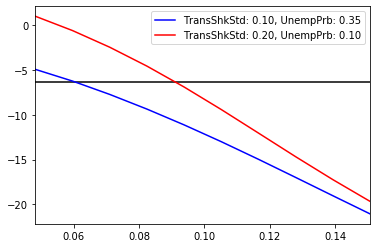

In [18]:
ratio_min = 0.8
perm_ratio_max = 2.5
num_points = 10
perm_min = BaselineType.PermShkStd[0] * ratio_min
perm_max = BaselineType.PermShkStd[0] * perm_ratio_max
x = np.linspace(perm_min,perm_max,num_points)
plt.xlim(perm_min,perm_max)
TargetChangeInc = -6.3 # Source: FRED
plt.hlines(TargetChangeInC,perm_min,perm_max)


# The expression below shows the power of python
plt.plot(x,calcConsChangeAfterUncertaintyChange(ConsumerTypes,x,"PermShkStd","TransShkStd",0.10,"UnempPrb",0.35),c='b',label='TransShkStd: 0.10, UnempPrb: 0.35')
plt.plot(x,calcConsChangeAfterUncertaintyChange(ConsumerTypes,x,"PermShkStd","TransShkStd",0.20,"UnempPrb",0.10),c='r',label='TransShkStd: 0.20, UnempPrb: 0.10')
plt.legend()
plt.show()

The idea here is to consider how the different shocks depend on the values of the other shocks to show how the effect of permanent shocks on consumption depends on transitory shocks and unemployment shocks. The graph shows that if the probability of being unemployed is quite small, then a relative large permanent shock is required to bring forth a significant drop in non-durables consumption. Thus, the effect of permanent shocks depend on the probability of becoming unemployed.